In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sts
from tqdm import tqdm
from sklearn import metrics
from datetime import timedelta
from numpy import linalg

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_acf_pacf(timeseries):
    """
    Функция, отображающая график временного ряда, 
    автокорреляционную функцию(ACF)
    и частную автокорреляционную функцию(PACF).
    """
    fig = plt.figure(figsize=(16,20))
    
    ax0 = fig.add_subplot(311)
    timeseries.plot(ax=ax0)
    ax0.set_title('График временного ряда')
    ax0.set_xlabel('Дата')
    ax0.set_ylabel('Количество новых заболеваний')
    
    ax1 = fig.add_subplot(312)
    fig = sm.graphics.tsa.plot_acf(timeseries, ax=ax1)
    ax1.set_title('Автокорреляционная функция')
    
    ax2 = fig.add_subplot(313)
    fig = sm.graphics.tsa.plot_pacf(timeseries, ax=ax2)
    ax2.set_title('Частная автокорреляционная функция')
    
def adf_test(timeseries):
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='c')[1]
    print("Критерий Дики-Фуллера с константой: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ct')[1]
    print("Критерий Дики-Фуллера с константой и трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='ctt')[1]
    print("Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")
    pvalue = sm.tsa.stattools.adfuller(timeseries, regression='nc')[1]
    print("Критерий Дики-Фуллера без константы и тренда: p=%f" % pvalue)
    if pvalue > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

# Загрузка данных

In [3]:
ts = pd.read_excel('5lab.xlsx', index_col='date', parse_dates=['date'])['new_cases'].dropna() # !!!!!!!!!!
print(f"Длина временного ряда: {ts.shape[0]}")
ts = ts.resample('1W').mean()[:-1]
ts.head(15)

Длина временного ряда: 634


date
2020-03-08       0.333333
2020-03-15       4.714286
2020-03-22      28.142857
2020-03-29      67.285714
2020-04-05     111.857143
2020-04-12     184.428571
2020-04-19     145.142857
2020-04-26     226.714286
2020-05-03     327.000000
2020-05-10     485.000000
2020-05-17     644.428571
2020-05-24     800.142857
2020-05-31    1172.571429
2020-06-07    1407.571429
2020-06-14    1671.857143
Freq: W-SUN, Name: new_cases, dtype: float64

# Определение порядка разности d и компонент p, q.

### График временного ряда, АКФ и ЧАКФ

In [4]:
adf_test(ts)
plot_acf_pacf(ts)

Критерий Дики-Фуллера с константой: p=0.139186
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=0.464514
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.255819
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.156057
Ряд нестационарен


### График первых разностей

In [5]:
dif_1 = ts.diff().dropna()
adf_test(dif_1)
plot_acf_pacf(dif_1)

Критерий Дики-Фуллера с константой: p=0.000799
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.004165
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.017615
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000036
Ряд стационарен


### График вторых разностей

In [6]:
dif_2 = ts.diff().diff().dropna()
adf_test(dif_2)
plot_acf_pacf(dif_2)

Критерий Дики-Фуллера с константой: p=0.000015
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000169
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000858
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000001
Ряд стационарен


### p и q определяются по графикам АКФ и ЧАКФ для подходящего значения d

# Оценка параметров моделей

* Log Lokehood - логарифм правдоподобия
* S.D. of inovations - стандартная ошибка модели
* AIC - информационный критерий Аккаике
* BIC - информационный критерий Байеса
* HQIC - информационный критерий Хеннана-Куинна
* coef - значение коэффициента
* P>|z| - p-value для гипотезы о незначимости коэффициента (если больше 0.05 - незначим)

# Поиск 5 лучших моделей: перебор параметров

In [7]:
d = range(0, 4)
q = range(0, 8)
p = range(0, 8)

from itertools import product

parameters = list(product(p,d,q))
len(parameters)

256

In [8]:
# Может выполняться несколько минут
results = []
best_bic = float("inf")

for param in tqdm(parameters):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.ARIMA(ts, order=param).fit()
    except (ValueError, linalg.LinAlgError):
        continue
    bic = model.bic
    #сохраняем лучшую модель, bic, параметры
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.bic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
result_table.sort_values(by = 'bic', ascending=True).head(5)

100%|██████████| 256/256 [01:33<00:00,  2.74it/s]


parameters          bic
31  (1, 2, 1)  1589.885368
14  (0, 2, 4)  1592.378776
15  (0, 2, 5)  1593.148079
12  (0, 2, 2)  1594.414802
11  (0, 2, 1)  1595.474647

### Для начала поработаем с лучшей моделью (можно указать любую модель из 5)

In [9]:
model = sm.tsa.ARIMA(ts, order=(1, 2, 1)).fit() # !!!!!!!!!!!
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   89
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -785.965
Method:                       css-mle   S.D. of innovations           1625.442
Date:                Fri, 17 Dec 2021   AIC                           1579.931
Time:                        18:37:36   BIC                           1589.885
Sample:                    03-22-2020   HQIC                          1583.943
                         - 11-28-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.1653     13.867     -0.661      0.509     -36.345      18.014
ar.L1.D2.new_cases     0.5425      0.091      5.984      0.000       0.365       0.720
ma.L1.D2.new_cases    -1.0000      0.030    -33.085      0.000      -1.059      -0.941
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8434           +0.0000j            1.8434            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

---

# Проверка адекватности модели

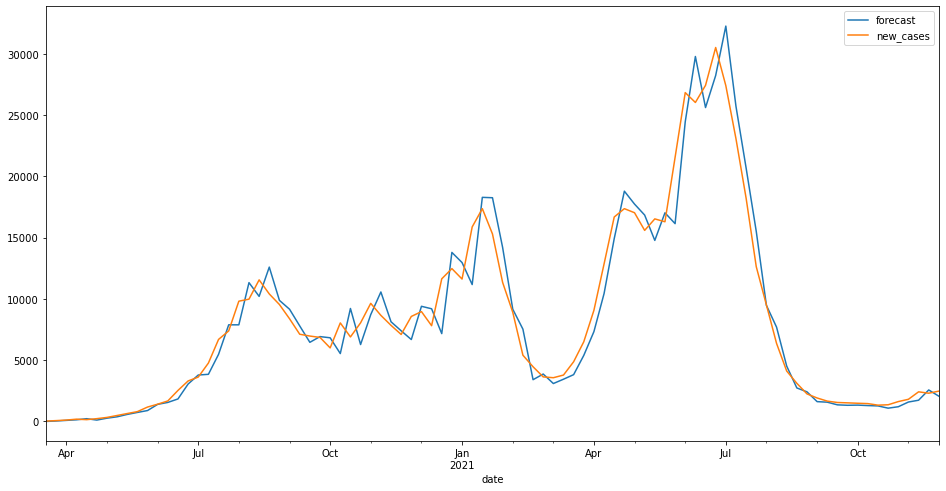

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(ax=ax)
fig.show()

In [11]:
pred = model.predict(typ='levels')
print('MSE =', metrics.mean_squared_error(ts[2:], pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts[2:], pred)))
print('MAE =', metrics.mean_absolute_error(ts[2:], pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts[2:], pred))
print('R2 =', metrics.r2_score(ts[2:], pred))

MSE = 2695970.757254549
RMSE = 1641.9411552350311
MAE = 1120.9507974549217
MAPE = 0.166956383000758
R2 = 0.949216706750042


# Проверка нормальности остатков

In [12]:
resid = pd.DataFrame(model.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Критерий Дики-Фуллера с константой: p=0.998971
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.997120
Ряд нестационарен


Тест на нормальность: p = 0.018777
Распределение остатков ненормальное


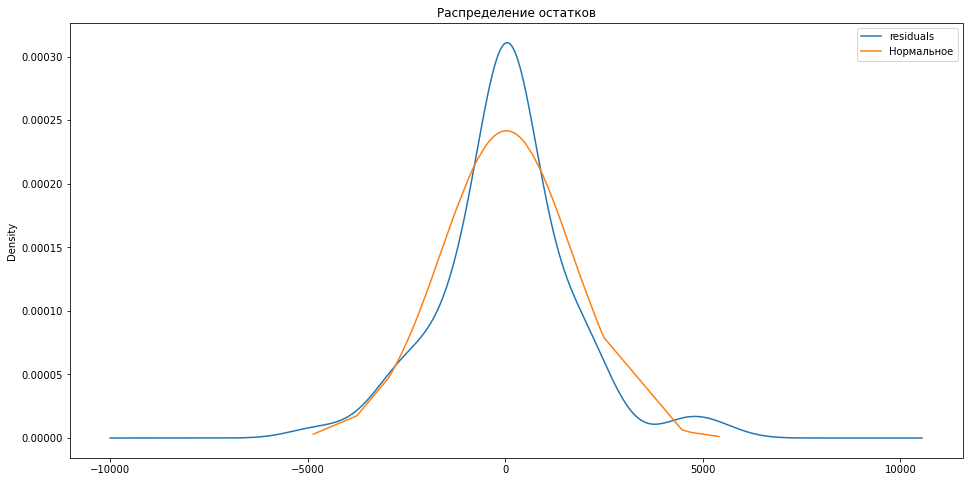

In [13]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

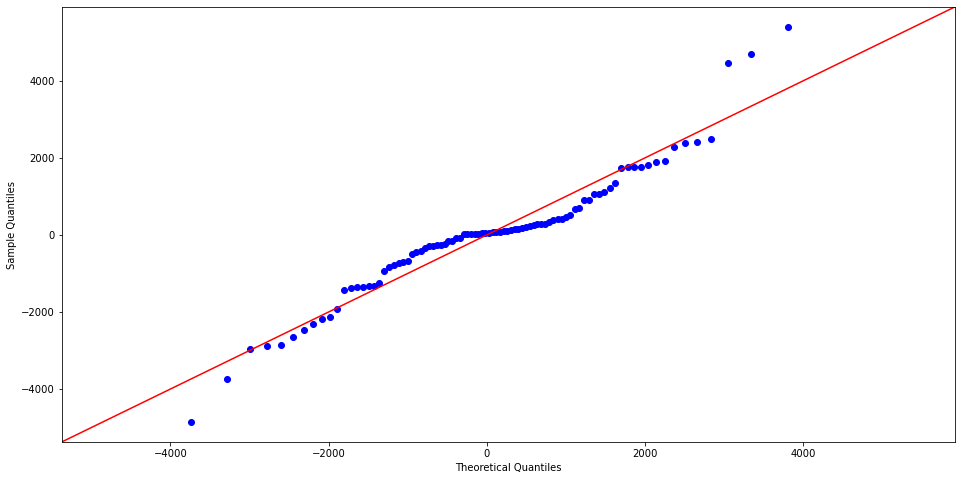

In [14]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.new_cases   No. Observations:                   89
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -785.965
Method:                       css-mle   S.D. of innovations           1625.442
Date:                Fri, 17 Dec 2021   AIC                           1579.931
Time:                        18:37:37   BIC                           1589.885
Sample:                    03-22-2020   HQIC                          1583.943
                         - 11-28-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -9.1653     13.867     -0.661      0.509     -36.345      18.014
ar.L1.D2.new_cases     0.5425      0.091      5.984      0.000       0.365       0.720
ma.L1.D2.new_cases    -1.0000      0.030    -33.085      0.000      -1.059      -0.941
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8434           +0.0000j            1.8434            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Последняя дата во временном ряду:  2021-11-28 00:00:00
Предсказание на 2 недели, до: 2021-12-12 00:00:00


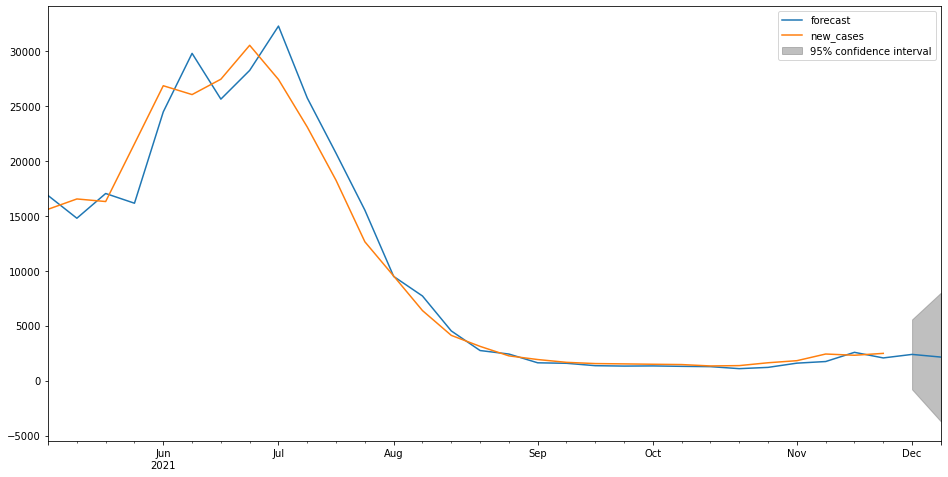

In [16]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
model.plot_predict(start=ts.index[-30], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), ax=ax)
fig.show()

In [17]:
pred = model.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-05    2378.852702
2021-12-12    2136.531379
Freq: W-SUN, dtype: float64

# Соберем ансамбль предсказаний

In [18]:
result_table.sort_values(by = 'bic', ascending=True).head(5)

parameters          bic
31  (1, 2, 1)  1589.885368
14  (0, 2, 4)  1592.378776
15  (0, 2, 5)  1593.148079
12  (0, 2, 2)  1594.414802
11  (0, 2, 1)  1595.474647

## Меняем параметры моделей на табличные

In [19]:
model1 = sm.tsa.ARIMA(ts, order=(1, 2, 1)).fit()
model2 = sm.tsa.ARIMA(ts, order=(0, 2, 4)).fit()
model3 = sm.tsa.ARIMA(ts, order=(0, 2, 5)).fit()
model4 = sm.tsa.ARIMA(ts, order=(0, 2, 2)).fit()
model5 = sm.tsa.ARIMA(ts, order=(0, 2, 1)).fit()

## Сохраняем предсказания ансамбля и доверительные интервалы в Excel-файл

In [20]:
forecast = pd.DataFrame(index=pred.index)
res1 = model1.forecast(weeks_pred)
res2 = model2.forecast(weeks_pred)
res3 = model3.forecast(weeks_pred)
res4 = model4.forecast(weeks_pred)
res5 = model5.forecast(weeks_pred)
forecast['value1'] = res1[0]
forecast['value2'] = res2[0]
forecast['value3'] = res3[0]
forecast['value4'] = res4[0]
forecast['value5'] = res5[0]
forecast['result'] = (forecast['value1']+forecast['value2']+forecast['value3']+forecast['value4']+forecast['value5'])/5
forecast['left_border'] = [x[0] for x in res1[2]]
forecast['right_border'] = [x[1] for x in res1[2]]
forecast.to_excel('forecast.xlsx')
forecast

value1       value2       value3       value4       value5  \
2021-12-05  2378.852702  2399.350659  2498.455387  2394.506339  2619.472223   
2021-12-12  2136.531379  2316.212347  2514.687737  2306.180790  2767.319283   

                 result  left_border  right_border  
2021-12-05  2458.127462  -806.955857   5564.661260  
2021-12-12  2408.186307 -3719.859943   7992.922701

# Добавим сезонность и построим SARIMA

Общий вид модели - **SARIMA (p,d,q) (P,D,Q) s**

* p - порядок модели AR
* d - порядок интегрирования
* q - порядок модели MA
* P - порядок сезонной составляющей SAR
* D - порядок интегрирования сезонной составляющей
* Q - порядок сезонной составляющей SMA
* s - размерность сезонности

### Для начала надо провести сдвиг по сезонности, можно попробовать разные, рекомендуемый 4-6 месяцев.

In [21]:
months_seasonal = 6 # !!!!!!!!!!!!


ts_4m = ts.diff(4*months_seasonal).dropna()
print("Сезонная разность:")
adf_test(ts_4m)

print("-"*30)
dif_4m = ts.diff(4*months_seasonal).diff().dropna()
print("Интегрированная сезонная разность:")
adf_test(dif_4m)

# dif2_4m = ts.diff(30*monhts_seasonal).diff().diff().dropna()
# adf_test(dif2_4m)

fig = plt.figure(figsize=(16,30))
    
ax0 = fig.add_subplot(411)
ts_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=0')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax0 = fig.add_subplot(412)
dif_4m.plot(ax=ax0)
ax0.set_title('Сезонная разность d=1')
ax0.set_xlabel('Дата')
ax0.set_ylabel('Количество новых заболеваний')

ax1 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(dif_4m, ax=ax1)
ax1.set_title('Автокорреляционная функция')

ax2 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_pacf(dif_4m, ax=ax2)
ax2.set_title('Частная автокорреляционная функция')

fig.show()

Сезонная разность:
Критерий Дики-Фуллера с константой: p=0.965063
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=0.966488
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.895547
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.557296
Ряд нестационарен
------------------------------
Интегрированная сезонная разность:
Критерий Дики-Фуллера с константой: p=0.000000
Ряд стационарен
Критерий Дики-Фуллера с константой и трендом: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=0.000001
Ряд стационарен
Критерий Дики-Фуллера без константы и тренда: p=0.000000
Ряд стационарен


### P и Q определяются по графикам АКФ и ЧАКФ для подходящего значения D сезонной разности

In [22]:
%%time 

#Модель SARIMA может тренироваться долго - если ставить значения параметров больше 1 время растет в геометрической прогресии... 

p = 1
d = 2
q = 1
P = 1
D = 1
Q = 1
s = 4*months_seasonal

sarima = sm.tsa.statespace.SARIMAX(ts, order=(p, d, q), 
                                seasonal_order=(P, D, Q, s)).fit()
print(sarima.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                          new_cases   No. Observations:                   91
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 24)   Log Likelihood                -581.558
Date:                            Fri, 17 Dec 2021   AIC                           1173.115
Time:                                    18:37:43   BIC                           1183.987
Sample:                                03-08-2020   HQIC                          1177.405
                                     - 11-28-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3975      0.163      2.433      0.015       0.077       0.718
ma.L1         -0.9983      2.945   

---

# Проверка адекватности сезонной модели

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(typ='levels')
pred.plot(ax=ax)
ts.plot(ax=ax)
plt.legend()
fig.show()

In [24]:
print('MSE =', metrics.mean_squared_error(ts, pred))
print('RMSE =', np.sqrt(metrics.mean_squared_error(ts, pred)))
print('MAE =', metrics.mean_absolute_error(ts, pred))
print('MAPE =', metrics.mean_absolute_percentage_error(ts, pred))
print('R2 =', metrics.r2_score(ts, pred))

MSE = 2689470.710581422
RMSE = 1639.9605820206234
MAE = 1146.5388453309058
MAPE = 0.21701440305497943
R2 = 0.949579721150324


# Проверка нормальности остатков

In [25]:
resid = pd.DataFrame(sarima.resid, columns=['residuals']).sort_values(by='residuals')
adf_test(resid)
plot_acf_pacf(resid)

Критерий Дики-Фуллера с константой: p=0.998838
Ряд нестационарен
Критерий Дики-Фуллера с константой и трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера с константой, линейным и квадратичным трендом: p=1.000000
Ряд нестационарен
Критерий Дики-Фуллера без константы и тренда: p=0.994960
Ряд нестационарен


Тест на нормальность: p = 0.007995
Распределение остатков ненормальное


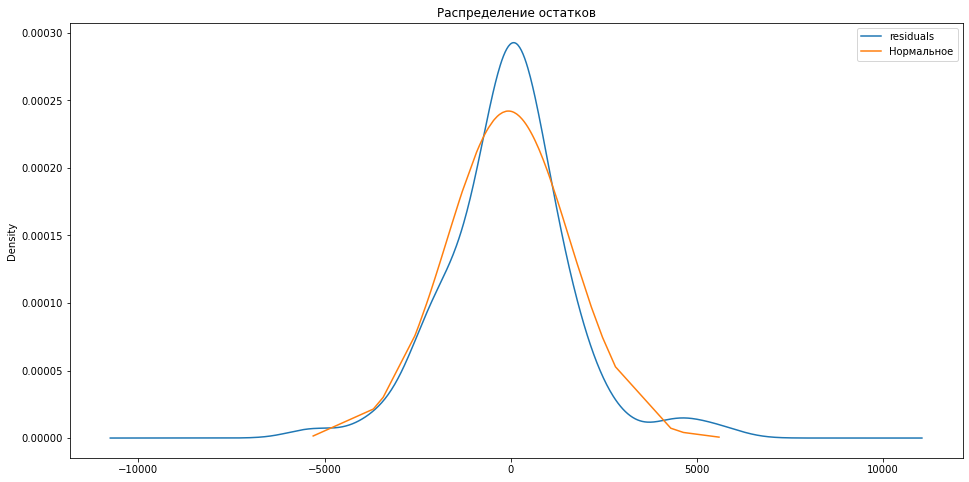

In [26]:
pvalue = sts.normaltest(resid['residuals'])[1]
print("Тест на нормальность: p = %f" % pvalue)
if pvalue > 0.05:
    print("Распределение остатков нормальное")
else:
    print("Распределение остатков ненормальное")

fig, ax = plt.subplots(figsize=(16,8))
resid.plot.kde(ax=ax)
plt.title('Распределение остатков')
plt.plot(resid, sts.norm.pdf(resid, resid.mean(), resid.std()), label='Нормальное')
plt.legend()
fig.show()

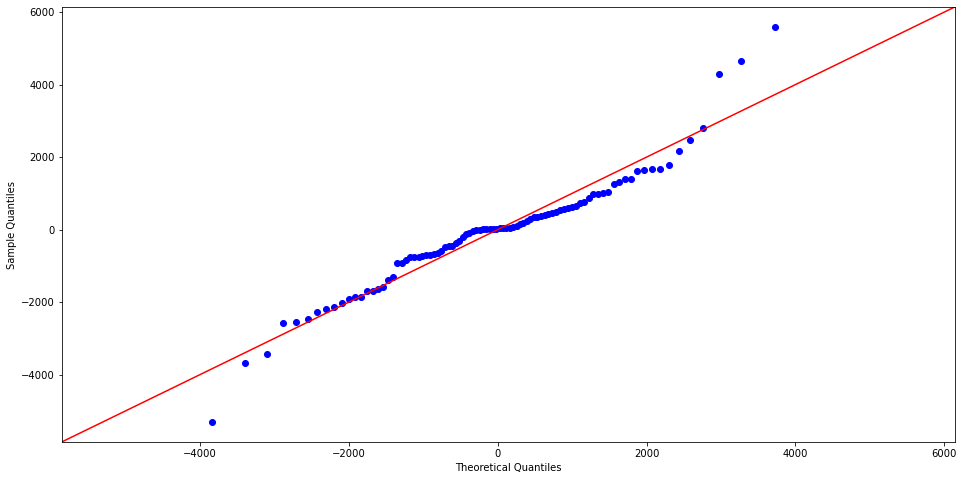

In [27]:
fig, ax = plt.subplots(figsize=(16,8))
sm.qqplot(resid['residuals'], loc=resid['residuals'].mean(), scale = resid['residuals'].std(), line='45', ax=ax)
fig.show()

# Предсказание будущих показателей

In [28]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                   91
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 24)   Log Likelihood                -581.558
Date:                            Fri, 17 Dec 2021   AIC                           1173.115
Time:                                    18:37:43   BIC                           1183.987
Sample:                                03-08-2020   HQIC                          1177.405
                                     - 11-28-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3975      0.163      2.433      0.015       0.077       0.718
ma.L1         -0.9983      2.945     -0.339      0.735      -6.771       4.774
ar.S.L24       0.0154      0.262      0.059      0.953      -0.499       0.529
ma.S.L24      -0.9926      2.948     -0.337      0.736      -6.771       4.786
sigma2      2.367e+06   1.27e-06   1.87e+12      0.000    2.37e+06    2.37e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 5.25
Prob(Q):                              0.82   Prob(JB):                         0.07
Heteroskedasticity (H):               0.72   Skew:                             0.27
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.73e+28. Standard errors may be unstable.
"""

In [29]:
weeks_pred = 2 # количество недель для предсказания !!!!!!!!!!!!!

print("Последняя дата во временном ряду: ", ts.index[-1])
print(f"Предсказание на {weeks_pred} недели, до: {ts.index[-1] + timedelta(weeks=weeks_pred)}")

fig, ax = plt.subplots(figsize=(16,8))
pred = sarima.predict(start=ts.index[-20], end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred.plot(ax=ax)
ts[-20:-1].plot(ax=ax)
plt.legend()
fig.show()

Последняя дата во временном ряду:  2021-11-28 00:00:00
Предсказание на 2 недели, до: 2021-12-12 00:00:00


In [30]:
pred = sarima.predict(start=ts.index[-1] + timedelta(days=1), end=(ts.index[-1] + timedelta(weeks=weeks_pred)), typ='levels')
pred

2021-12-05    2731.524134
2021-12-12    4296.802080
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Сохраняем предсказания и доверительные интервалы в Excel-файл

In [31]:
forecast = pd.DataFrame(columns=['value'], index=pred.index)
res = sarima.forecast(weeks_pred)
forecast['value'] = res
forecast.to_excel('forecast_sarima.xlsx')
forecast

value
2021-12-05  2731.524134
2021-12-12  4296.802080